## Conflict and Movement in Syria, 2019-2020
### UIUC, iSchool, IS590PR, Spring 2020, Final Project
#### By Derek Harootune Otis

### Part One: Introduction
---

This project analyzes the movement of internally displaced persons within Syria in relation to the ebb and flow of Syria's ongoing civil war. It evaluates changes in three conflict-related variables in relation to changes in IDP movement, hoping to identify candidate features for future predictive modeling of IDP movement in the region. Additionally, it examines how the relationship between these variables and IDP movement differs across Syria's governorates.

#### Term Definitions
---
**Internally Displaced Person (IDP)** - "\[P\]ersons or groups of persons who have been forced or obliged to flee or to leave
their homes or places of habitual residence, in particular as a result of or in order
to avoid the effects of armed conflict, situations of generalized violence, violations
of human rights or natural or human-made disasters, and who have not crossed an
internationally recognized state border." Definition from the [OCHA Guiding Principles on Internal Displacement](https://www.internal-displacement.org/sites/default/files/publications/documents/199808-training-OCHA-guiding-principles-Eng2.pdf)

**IDP Movement** - The number of individuals forced to move from a place of origin to a new place. Counts of IDP movement are extracted from OCHA Turkey's "Syrian Arab Republic: IDP movements and IDP spontaneous return movements Data" dataset (see below)

**Conflict Event** - A single conflict-related observation as recorded in the ACLED's "Syrian Arab Republic - Conflict Data" dataset (see below). These vary widely in nature, from "strategic developmemnts" to direct attacks against civilians.

#### Datasets
---
1. [Syrian Arab Republic: IDP movements and IDP spontaneous return movements Data](https://data.humdata.org/dataset/syrian-arab-republic-idp-movements-and-idp-spontaneous-return-movements-data)
2. [Syrian Arab Republic - Conflict Data](https://data.humdata.org/dataset/acled-data-for-syrian-arab-republic)

#### Characterization of Correlations
---
For the purposes of this analysis, the following ranges of Pearson's r correlation values are shorthanded using the corresponding adjectives:

- |r| < 0.1 -> Minimal
- 0.1 <= |r| < 0.3 -> Low
- 0.3 <= |r| < 0.7 -> Moderate
- 0.7 < |r| -> Strong

#### Hypotheses
---
These hypotheses are not rigorously crafted experimental hypotheses, as this is not an experiment. Rather, they are "common-sense" intuitions based on the nature of each pair of variables, which guide this analysis and are tested within it.

1. Change in the number conflict events is at least moderately positively correlated with change in the number of IDP movements at the national level.

2. Change in the number of conflict events involving non-combatants has a more strongly positive correlation with change in the number of IDP movements compared with change in the number of conflict events overall, at the national level.

3. Change in the number of fatalities is at least moderately positively correlated with change in the number of IDP movements at the national level.
---

*Setting the stage - imports, data processing*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from conflict_movement_analysis_utils import *
%matplotlib inline

# reused variables
date_codes = ['2019-1', '2019-2', '2019-3', '2019-4', '2019-5', '2019-6', '2019-7', '2019-8', '2019-9', '2019-10',
              '2019-11', '2019-12', '2020-1', '2020-2']

districts = ["Aleppo", "Al-Hasakeh", "Ar-Raqqa", "As-Sweida", "Damascus", "Dar'a", "Deir-ez-Zor",
             "Hama", "Homs", "Idleb", "Lattakia", "Quneitra", "Rural Damascus", "Tartous"]

# paths to data files
conflict_data_path = 'data/conflict_data_syr.csv'

idp_data_paths = ['data/01_idp_jan_19.xlsx', 'data/02_idp_feb_19.xlsm', 'data/03_idp_mar_19.xlsm',
                  'data/04_idp_apr_19.xlsm', 'data/05_idp_may_19.xlsm', 'data/06_idp_jun_19.xlsm',
                  'data/07_idp_jul_19.xlsm', 'data/08_idp_aug_19.xlsx', 'data/09_idp_sep_19.xlsx',
                  'data/10_idp_oct_19.xlsx', 'data/11_idp_nov_19.xlsx', 'data/12_idp_dec_19.xlsx',
                  'data/13_idp_jan_20.xlsx', 'data/14_idp_feb_20.xlsx']

# Extract basic data from files
conflict_data = clean_conflict_data(conflict_data_path)

idp_data = aggregate_idp_data(idp_data_paths, date_codes, districts)

### Part Two: Hypothesis Testing

#### Testing The First Hypothesis
---

In [2]:
corr_deltas = calculate_conflict_movement_correlation(conflict_data, idp_data, date_codes, delta=True).loc['conflict']['movement']

print(f'Pearson\'s r correlation between % change in conflict events and IDP movement counts by month:\n{round(corr_deltas, 4)}')

Pearson's r correlation between % change in conflict events and IDP movement counts by month:
0.0834


We find that there is a minimal positive correlation between percent change of conflict event count and percent change in IDP movement count by month, which fails to support the first hypothesis.

#### Digging Deeper - Correlation of Conflict and Movement by Governorate
---

Though comparing change in grand totals reveals only a minimally positive relationship between change in conflict and change in movement, the statistical picture of these two variables becomes much more complex once we investigate the correlation between them at the governorate level.

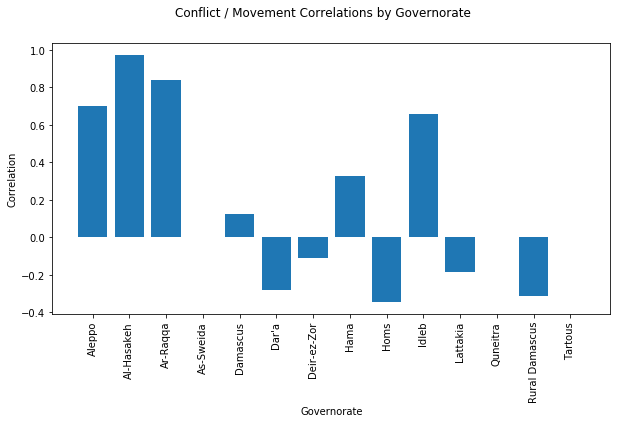

In [3]:
corr_bar = district_wise_correlations(districts, conflict_data, idp_data, date_codes, delta=True)

display_cm_correlation_bar_graph(corr_bar, 'Conflict / Movement Correlations by Governorate')

In fact, we see a wide variety of different relationships represented at this level of detail. This suggests the presence of one or more external variables which affect the degree to which conflict and movement are related - or, perhaps, exert some effect on conflict and movement such that the two appear correlated in some cases, and appear unrelated in others.

#### Geographic and Political Commonalities
---
One clue which may reveal what these external variables are is the geographic clustering of governorates which exhibit correlations of a similar sign. 

Here are the correlations of governorates with a positive correlation between change in number of conflict events and change in number of IDP movements.



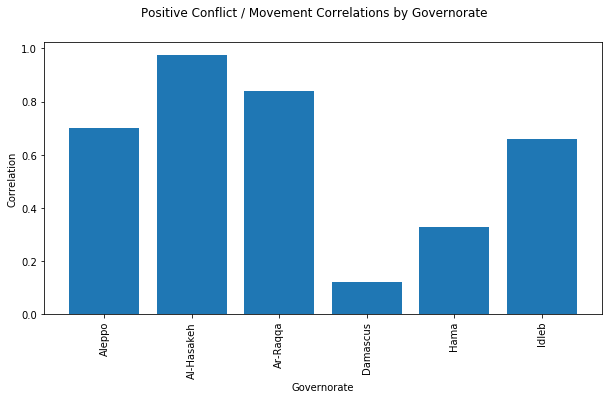

In [4]:
positive_corr_bar = corr_bar.query('correlation > 0')

display_cm_correlation_bar_graph(positive_corr_bar, 'Positive Conflict / Movement Correlations by Governorate')

Here are those same governorates highlighted on a map of Syria (map courtesy of [d-maps](https://d-maps.com/carte.php?num_car=56601&lang=en)):

![alt text](./img/syria.png "Map of syria with positive correlation governorates marked in pink")

(IMPORTANT NOTE: Damascus is highlighted for completeness, but its demonstrated positive correlation is low)

Let us compare these positions with a conflict map of Syria as of September 2019, towards the middle of the time period studied in this analysis (map courtesy of [polgeonow](www.polgeonow.com)).

![alt text](https://1.bp.blogspot.com/-M1NO-ELPqYA/XXssPUmFShI/AAAAAAAAC3c/p1HZwbNvI6shfXuq_qhAvmZqYwSI8ULXACLcBGAsYHQ/s1600/2019-09-10_syria-control-map-kurds-isis-rebels.jpg "A map of Syria as of September 2019")

As this map demonstrates, many of Syria's most divided and contested regions are located in the north of the country. These regions have rapidly changing borders and lines of battle, widely differing cultures, and many other special circumstances which may affect both the shape of conflict and IDP movement within them. 

The governorates in these regions also often exhibit moderate or strong positive correlations between change in number of conflict events and change in number of IDP movements by month, while most southern governorates do not. Future investigators who wish to model these aspects of the Syrian conflict in relation to one another should consider examining these regions in close detail.

#### Testing the Second Hypothesis
---

In [5]:
corr_civ_deltas = calculate_conflict_movement_correlation(conflict_data, idp_data, date_codes, party='Civilians', delta=True).loc['conflict']['movement']

print(f'Pearson\'s r correlation between % change in conflict events involving civilians and IDP movement counts by month:\n{round(corr_civ_deltas, 4)}')

Pearson's r correlation between % change in conflict events involving civilians and IDP movement counts by month:
-0.3478


We find that the correlation between percent change in number of conflict events involving civilians and IDP movement counts is not more strongly positive than the correlation of change in number of all conflict events with IDP movement. In fact, there is a moderate *negative* relationship between these two variables. This clearly does not support the second hypothesis, and bears further discussion.

Given the data and level of analysis being done in the context of this project, **it is impossible to pinpoint the reason behind this counterintuitive r value**. We are working with a low number of observations, only 12 (12 month-to-month changes), and the quality of the individual observations aggregated into our month-to-month observations [varies](https://www.dropbox.com/s/ifm90oxlx5xt04u/IDPs%20Methodology%20for%202017.docx?dl=0). However, these limitations apply to the entirety of this analysis, and can be set aside for the sake of speculation.

If we imagine this relationship holds true for larger sets of observations, there are two broad categories of potential causes for it. First, there are numerous potential external variables, which are difficult to speculate on. Alternatively, if this negative, moderate correlation happens to reflect a cause-and-effect relationship between our two variables, the negative sign of this correlation may indicate that the direct effects of civilian-involved conflict on movement (or vice-versa) has unanticipated dimensions. For example, higher numbers of attacks against civilians may create an unsafe environment for travel, discouraging movement. Higher numbers of attacks may also directly compromise transport infrastructure, such as public transport, road, and rail.

#### Breaking Civilian-Involved Events Down by Governorate
---

To further explore this relationship in a similar way to the first hypothesis, let's perform the same follow-up treatment on our second hypothesis' dataset as we did on the first's.

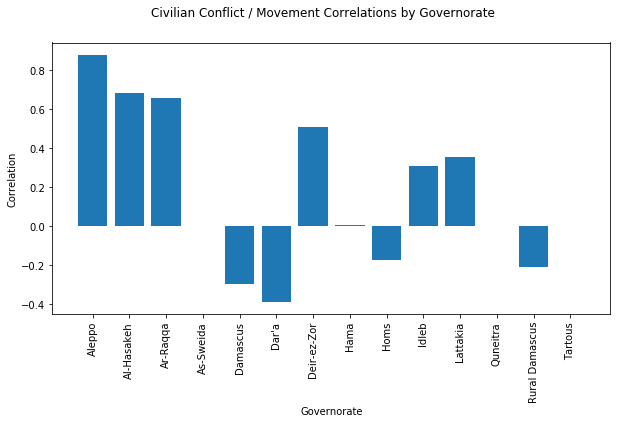

In [6]:
corr_civ_bar = district_wise_correlations(districts, conflict_data, idp_data, date_codes, party='Civilians', delta=True)

display_cm_correlation_bar_graph(corr_civ_bar, 'Civilian Conflict / Movement Correlations by Governorate')

We see a similar pattern as before emerge from this data set. This is somewhat surprising considering the differences we've observed so far. The geographic clustering described before also emerges again, and on a surface level, appears even more pronounced in this data set.

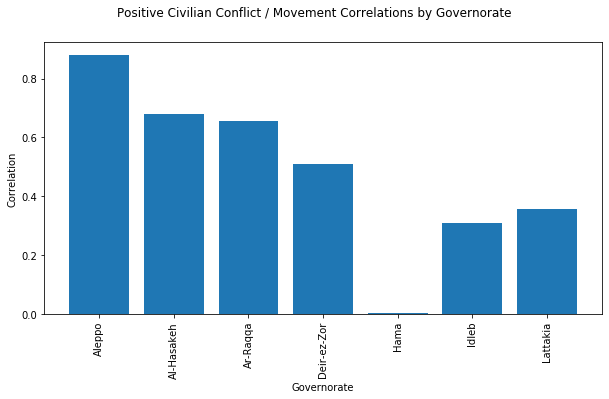

In [7]:
positive_corr_civ_bar = corr_civ_bar.query('correlation > 0')

display_cm_correlation_bar_graph(positive_corr_civ_bar, 'Positive Civilian Conflict / Movement Correlations by Governorate')

![alt text](./img/syria-2.png "Map of syria with positive correlation governorates marked in pink (civilian conflict)")

(IMPORTANT NOTE: Hama is highlighted for completeness, but its demonstrated positive relationship is **extremely** minimal)

Once again, it seems prudent for future investigators to examine the circumstances of these northern, contested governorates for features which may play a critical role in predicting IDP movement and/or conflict events.

#### Testing the Third Hypothesis
---

In [8]:
corr_fatal_deltas = calculate_conflict_movement_correlation(conflict_data, idp_data, date_codes, delta=True, fatal=True).loc['conflict']['movement']

print(f'Pearson\'s r correlation between % change in fatalities and IDP movement counts by month:\n{round(corr_fatal_deltas, 4)}')

Pearson's r correlation between % change in fatalities and IDP movement counts by month:
0.1613


We find that there is a low positive correlation between percent change of conflict event count and percent change in IDP movement count by month, which fails to support the third hypothesis as written.

This is so far the strongest positive relationship between change in a conflict-related variable and change in IDP movement at the country level, though it is by no means a good one.

#### At the Governorate Level
---

More interestingly, when we measure this hypothesis' two variables by governorate, we see a similar pattern of varying relationships appear *yet again*.

In [ ]:
corr_fatal_bar = district_wise_correlations(districts, conflict_data, idp_data, date_codes, delta=True, fatal=True)

display_cm_correlation_bar_graph(corr_fatal_bar, 'Fatality / Movement Correlations by Governorate')

By "similar pattern", I do not just mean that we see varying correlation by governorate. That itself would not be surprising. However, several of *the same* governorates exhibit moderate-to-strong correlations between conflict related events across all three data subsets. Specifically, **Aleppo**, **Al-Hasakeh**, **Ar-Raqqa**, and **Idleb** exhibit moderate or strong correlation between change in a conflict-related variable and change in IDP movement in all three subsets.

In [ ]:
positive_corr_fatal_bar = corr_fatal_bar.query('correlation > 0')

display_cm_correlation_bar_graph(positive_corr_fatal_bar, 'Positive Fatality / Movement Correlations by Governorate')

![alt text](./img/syria-3.png "Map of syria with positive correlation governorates marked in pink (fatalities)")

(IMPORTANT NOTE: Damascus and Dair-ez-Zor are included for completeness, though their correlations are low)

The persistence of this pattern through the test of change in fatalities as related to change in movement is particularly notable. The second conflict-related variable tested against IDP movement, in this analysis, was effectively a subset of the first. Each are expressions of change in month-to-month counts of conflict events, and further investigation may find that the proportion of those events involving civilians clusters relatively closely around some average value across Syria's governorates. 

However, the third test's conflict-related variable is an expression of change in number of fatalities, a variable which, while related to overall number of events, is not so nearly closely related to it. Event types vary from 'Strategic Developments' to 'Battles' to 'Abductions', while number of fatalities can vary significantly within event types.

#### Conclusions
---

None of our original hypotheses, as written, were supported. Actual observed correlations between change in IDP movement and the selected conflict-related variables ranged from low to moderately negative. Thus, none of these conflict-related variables present themselves as likely candidate features for predictive modeling of IDP movement in Syria. The second variable tested, change in number of conflict events involving civilians, may be an exception as it exhibited a moderately negative relationship with overall IDP movement. However, the nature and potential causes of this relationship should be examined more carefully and more thoroughly than has been done here before it is used seriously for modeling at the national level.

That being said, at the governorate level, we found that certain conflict-related variables were very strongly correlated with movement. For example, change in overall number of events was strongly correlated with change in number of IDP movements in Al-Hasakeh; change in civilian-involved events was strongly correlated with movement in Aleppo; and change in fatalities was strongly correlated with movement in Raqqa. With further testing, these may already prove to be strong candidate features for movement prediction in these regions.

Another exciting result of this analysis emerged from the follow-up break-down of each tested relationship to the governorate level. Several geographically-clustered northern governorates exhibited consistently moderate or strong positive correlations between all three tested conflict-related variables. Though it is impossible to determine the exact cause of this pattern, its presence should be taken as a cue by future investigators to examine Syria's contested northern districts for unique features which may affect the apparent relationship between conflict and movement.

#### Limitations & Notes
---

Due to the nature of the data used in this exploration, there are a number of potential limitations on data collection which affect the quality of the data collected. Conclusions are made under the assumption that these limitations remain relatively constant over time, which would presumably safeguard model reliability.

For current documentation of OCHA Turkey's IDP data collection methodology and potential limitations, see the "Methodology" field under the Metadata tab on the [download page for the IDP dataset](https://data.humdata.org/dataset/syrian-arab-republic-idp-movements-and-idp-spontaneous-return-movements-data).

For current documentation on the ACLED's data collection and curation methodology, see the [ACLED's methodology page](https://acleddata.com/resources/methodology/).

Future investigations of correlation in specific governorates should calculate p-values for these governorates' correlation coefficients. Support for this feature will be added to the library underpinning this document in a future release.